# Delineation annotation evaluation
In this homework, you will work on a specific type of annotation on an ECG, sometimes referred to as "delineation".
It consists in the segmentation and labelling of certain moments (called "waves") of the heart's cycle on the ECG.

## The data
You have 4 examples with the following ids: "sinus", "pvc", "afib" and "artefacts". For each, you get:
- the 10 seconds ECG signal with 2 channels sampled at 250 Hz in the form of a numpy array
- 3 annotations for each stored in JSON format: 1 reference annotation ("truth") and 2 different annotations ("ann_A", "ann_B")

In the annotations, you will find waves of different types:
- P waves correspond to the contraction of the atria
- QRS waves correspond to the contraction of the ventricles
- T waves correspond to the reloading of the ventricles

To learn more about ECG waves, check out this video: https://www.youtube.com/watch?v=RYZ4daFwMa8

A normal heart beat is usually made of a P wave followed by a QRS and a T wave. Note: in the annotations, T wave's onset may differ from the previous QRS wave's offset but by convention it will be considered to be the QRS wave's offset.

Abnormal heart beats always have a QRS and a T (possibly no P wave, or there can be a P wave without a beat) but they can be triggered by abnormal mechanisms. These mechanisms are represented by the "label" field on each wave's annotation. The available labels are:
- "N" is for normal P and QRS waves
- "A" on P waves is when they come from an abnormal place in the atria
- "A" on QRS waves is when they are issued from an "A" P wave
- "V" on QRS waves is when they come from an abnormal place in the ventricles
- "O" is for all other abnormalities on P and QRS waves

Note that wave onsets and offsets are provided in milliseconds.

*1) Write a function to display the annotation on top of the ECG signal. Use it to display the reference annotation of the ECG labelled "sinus".*

In [1]:
!unzip -o data_eng_homework.zip
!mv data_eng_homework/data .
!rm -rf data_eng_homework

Archive:  data_eng_homework.zip
   creating: data_eng_homework/
  inflating: data_eng_homework/data_eng_homework.ipynb  
   creating: data_eng_homework/data/
   creating: data_eng_homework/data/annotations/
  inflating: data_eng_homework/data/annotations/artefacts-ann_B.json  
  inflating: data_eng_homework/data/annotations/artefacts-ann_A.json  
  inflating: data_eng_homework/data/annotations/artefacts-truth.json  
  inflating: data_eng_homework/data/annotations/afib-ann_B.json  
  inflating: data_eng_homework/data/annotations/afib-ann_A.json  
  inflating: data_eng_homework/data/annotations/afib-truth.json  
  inflating: data_eng_homework/data/annotations/sinus-ann_B.json  
  inflating: data_eng_homework/data/annotations/sinus-ann_A.json  
  inflating: data_eng_homework/data/annotations/sinus-truth.json  
  inflating: data_eng_homework/data/annotations/pvc-ann_B.json  
  inflating: data_eng_homework/data/annotations/pvc-ann_A.json  
  inflating: data_eng_homework/data/annotations/pvc

In [2]:
!head data/annotations/sinus-ann_A.json

[{"onset":26,"offset":138,"type":"P","label":"O"},{"onset":202,"offset":298,"type":"QRS","label":"O"},{"onset":298,"offset":593,"type":"T","label":""},{"onset":1110,"offset":1214,"type":"P","label":"O"},{"onset":1292,"offset":1401,"type":"QRS","label":"O"},{"onset":1401,"offset":1703,"type":"T","label":""},{"onset":2259,"offset":2377,"type":"P","label":"O"},{"onset":2435,"offset":2536,"type":"QRS","label":"O"},{"onset":2536,"offset":2863,"type":"T","label":""},{"onset":3422,"offset":3532,"type":"P","label":"O"},{"onset":3600,"offset":3702,"type":"QRS","label":"O"},{"onset":3702,"offset":4009,"type":"T","label":""},{"onset":4532,"offset":4638,"type":"P","label":"O"},{"onset":4707,"offset":4799,"type":"QRS","label":"O"},{"onset":4799,"offset":5091,"type":"T","label":""},{"onset":5594,"offset":5708,"type":"P","label":"O"},{"onset":5764,"offset":5859,"type":"QRS","label":"O"},{"onset":5859,"offset":6162,"type":"T","label":""},{"onset":6691,"offset":6801,"type":"P","label":"O"},{"onset":686

In [0]:
import json
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import math
import matplotlib.pyplot as plt

In [0]:
SAMPLING_RATE = 250

def load(ecg_id):
    """Loads ECG signal and annotations for a label among: sinus, pvc, afib, artefact."""
    ecg = np.load("./data/ecgs/{}.npy".format(ecg_id))
    annotations = {}
    for ann in ("truth", "ann_A", "ann_B"):
        with open("./data/annotations/{}-{}.json".format(ecg_id, ann), 'r') as f:
            annotations[ann] = json.load(f)
    return ecg, annotations

In [0]:
def extract_waves(annotation, wave_type = "QRS"):
    df = pd.DataFrame(annotation)
    return df[df['type'] == wave_type][['onset', 'offset', 'label']].reset_index()

def display_annotation(ecg, annotation, wave_type = "QRS"):
    """Shows the contents of an annotation together with the original ECG"""
    dfECG = pd.DataFrame(ecg).T
    dfWave = extract_waves(annotation, wave_type)
    display(dfWave.T)

    nb_samples = len(dfECG)
    duration = nb_samples/SAMPLING_RATE * 1000
    X = pd.DataFrame(np.linspace(0.0, duration, num=2500))

    sns.set(rc={'figure.figsize':(20,8)}, style='darkgrid')
    sns.lineplot(X[0], dfECG[0])
    sns.lineplot(X[0], -dfECG[1])
    sns.scatterplot(dfWave['onset'], -0.1, marker='>')
    sns.scatterplot(dfWave['offset'], -0.1, marker='<')

    print(f"Total duration: {duration:,} ms")

,0,1,2,3,4,5,6,7,8
index,2,5,8,11,14,17,20,23,26
onset,939,2067,3158,4201,5221,6309,7443,8545,9627
offset,1058,2181,3254,4292,5317,6422,7537,8650,9720
label,O,O,O,O,O,O,O,O,O


Total duration: 10,000.0 ms


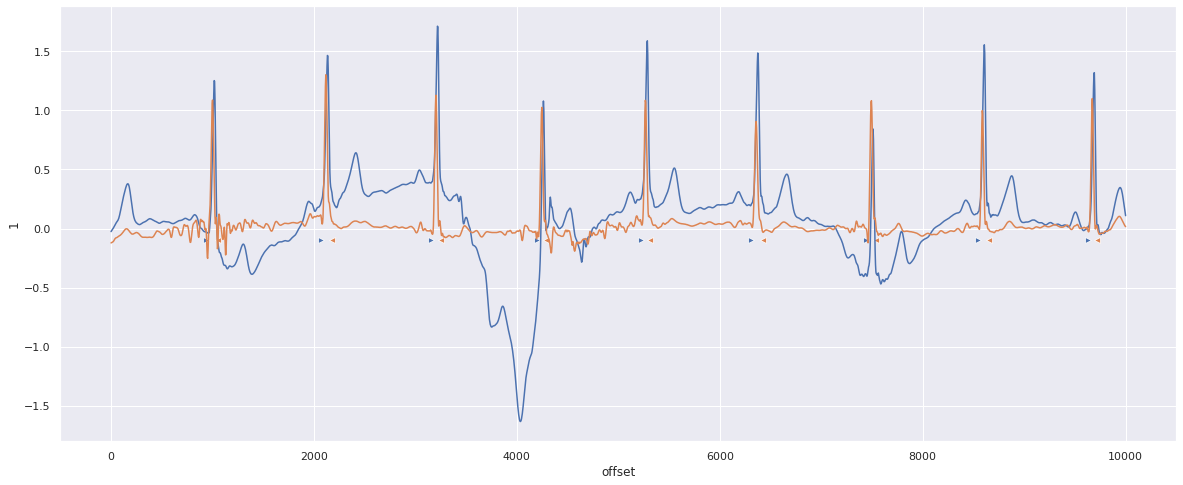

In [14]:
#@title Display ECG with annotations
ecg_id = "artefacts"                        # @param ["afib", "artefacts", "pvc", "sinus"]
ann_type = "ann_B"                      # @param ["truth", "ann_A", "ann_B"]
wave_type = "QRS"                       # @param ["P", "QRS", "T"]
ecg, annotations = load(ecg_id)
display_annotation(ecg, annotations[ann_type], wave_type)

## Evaluation
In this section we will propose an evaluation for an annotation compared to  the reference one.

Of the different wave types present in the annotations, since they are what makes a heart beat, QRS waves are the most critical.

*2) Write a function to compute the accuracy in QRS waves detection. A wave is considered correctly detected if it overlaps a wave of the same type in the reference annotation. Present the results in a pandas DataFrame.*

**ANSWER**

We use this methodology from scikit-learn: [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation)

In [0]:
truth = extract_waves(annotations['truth'], 'QRS')
predictions_A = extract_waves(annotations['ann_A'], 'QRS')
predictions_B = extract_waves(annotations['ann_B'], 'QRS')

TIME_FIELDS = ['onset', 'offset']

def _field_error(truth, predictions, field_name):
    """Error for the regression problem"""
    return mean_squared_error(truth[field_name], predictions[field_name])


def segmentation_error(truth, predictions, debug = False):
    """Global error for the regression problem"""
    if debug:
        display(truth[TIME_FIELDS].T)
        display(predictions[TIME_FIELDS].T)

    # Inconsistent number of samples truth.shape vs predictions.shape
    if len(truth) != len(predictions):
        return math.inf

    return (_field_error(truth, predictions, 'onset') + _field_error(truth, predictions, 'offset'))/2


print(f"segmentation_error of model A: {segmentation_error(truth, predictions_A, True):.2f}")
print(f"segmentation_error of model B: {segmentation_error(truth, predictions_B, True):.2f}")

def compute_errors(truth, predictions_A, predictions_B):
    """Return a summary dataframe with errors"""
    return pd.DataFrame(
        {'model_name':  ['A', 'B'], 'segmentation_error': [segmentation_error(truth, predictions_A), segmentation_error(truth, predictions_B)]}, 
        columns = ['model_name','segmentation_error']
    )

compute_errors(truth, predictions_A, predictions_B)

,0,1,2,3,4,5,6,7,8
onset,202,1295,2435,3600,4707,5764,6869,8013,9156
offset,298,1393,2536,3702,4799,5859,6974,8112,9258


,0,1,2,3,4,5,6,7,8
onset,202,1292,2435,3600,4707,5764,6869,8013,9156
offset,298,1401,2536,3702,4799,5859,6974,8112,9258


segmentation_error of model A: 4.06


,0,1,2,3,4,5,6,7,8
onset,202,1295,2435,3600,4707,5764,6869,8013,9156
offset,298,1393,2536,3702,4799,5859,6974,8112,9258


,0,1,2,3,4,5,6,7,8
onset,202,1292,2435,3600,4707,5764,6869,8013,9156
offset,298,1401,2536,3702,4799,5859,6974,8112,9258


segmentation_error of model B: 4.06


,model_name,segmentation_error
0,A,4.055556
1,B,4.055556


*3) The accuracy of QRS detection is a very partial information on the quality of an annotation. Propose and implement all additional metrics you think will help evaluate an annotation. Present the results in a pandas DataFrame.*

**ANSWER**

The annotated dataset shows there are two general machine learning problems :
- Segmentation: looking for bounds of the QRS wave (correct timeframes)
- Label: find the name of the wave and the category (N/A/V/O in the case QRS waves) (actually telling what the timeframe refers to)

Of course the same metrics can be computed for P and T waves as well depending on the "business criticity" of detecting such abnormal waves.

In [0]:
CATEGORY_NAME = 'label'

def encode(df):
    """Encode the strings into integers"""
    return pd.Series(df.values).map({'N': 0, 'A': 1, 'V': 2, 'O': 3})


def labelling_accuracy(truth, predictions, debug = False):
    """Accuracy for the classification problem"""
    if debug:
      display(truth[[CATEGORY_NAME]].T)
      display(predictions[[CATEGORY_NAME]].T)

    # Inconsistent number of samples: truth.shape vs predictions.shape
    if len(truth) != len(predictions):
        return 0.0

    return accuracy_score(encode(truth[CATEGORY_NAME]), encode(predictions[CATEGORY_NAME]))


print(f"labelling_accuracy of model A: {labelling_accuracy(truth, predictions_A, True):.2f}")
print(f"labelling_accuracy of model B: {labelling_accuracy(truth, predictions_B, True):.2f}")

def compute_accuracies(truth, predictions_A, predictions_B):
    """Return a summary dataframe with accuracies"""
    return pd.DataFrame(
        {'model_name':  ['A', 'B'], 'labelling_accuracy': [labelling_accuracy(truth, predictions_A), labelling_accuracy(truth, predictions_B)]}, 
        columns = ['model_name','labelling_accuracy']
    )

compute_accuracies(truth, predictions_A, predictions_B)

,0,1,2,3,4,5,6,7,8
label,N,N,N,N,N,N,N,N,N


,0,1,2,3,4,5,6,7,8
label,O,O,O,O,O,O,O,O,O


labelling_accuracy of model A: 0.00


,0,1,2,3,4,5,6,7,8
label,N,N,N,N,N,N,N,N,N


,0,1,2,3,4,5,6,7,8
label,O,O,O,O,O,O,O,O,O


labelling_accuracy of model B: 0.00


,model_name,labelling_accuracy
0,A,0.0
1,B,0.0


*4) Compare annotations A and B using your evaluation function. Discuss the results.*

In [0]:
for ecg_id in ["afib", "artefacts", "pvc", "sinus"]:
    print(f"ECG {ecg_id}:")
    ecg, annotations = load(ecg_id)
    truth = extract_waves(annotations['truth'], 'QRS')
    predictions_A = extract_waves(annotations['ann_A'], 'QRS')
    predictions_B = extract_waves(annotations['ann_B'], 'QRS')

    df1 = compute_errors(truth, predictions_A, predictions_B)
    df2 = compute_accuracies(truth, predictions_A, predictions_B)

    display(pd.merge(df1, df2, on='model_name'))

ECG afib:


,model_name,segmentation_error,labelling_accuracy
0,A,4.970588,0.647059
1,B,4.970588,0.764706


ECG artefacts:


,model_name,segmentation_error,labelling_accuracy
0,A,896.611111,0.777778
1,B,0.000000,0.000000


ECG pvc:


,model_name,segmentation_error,labelling_accuracy
0,A,0.5,0.111111
1,B,inf,0.000000


ECG sinus:


,model_name,segmentation_error,labelling_accuracy
0,A,4.055556,0.0
1,B,4.055556,0.0


**ANSWER**

In the ideal case, `accuracy` = 1 and `error` = 0.

- `error` rate is good for *afib* and *sinus* datasets
- `accuracy` of labelling was the best for *afib* dataset
- *Model B* performed well to segment the *artefacts* dataset but the performance was poor on labellng
- In the case of *pvc* dataset, *Model B* failed to segment one of the pattern. As you can debug in one of the cells above, there is one missing value and it is difficult to compute distance between two vectors
- *sinus* dataset looked like the cleanest ECG signal and the error of 4.05 can serve as a baseline to be approached with other datasets

## Interpretation (bonus)
This evaluation may be run on a large number of annotations which cannot be all easily reviewed like here.

*5) Implement a mechanism to find and visualise meaningful errors.*

**ANSWER**

Confusion matrix is a common technique to find out where the model in outperforming and to analyse misinterpretations further. The diagonal should be positive in the ideal case.

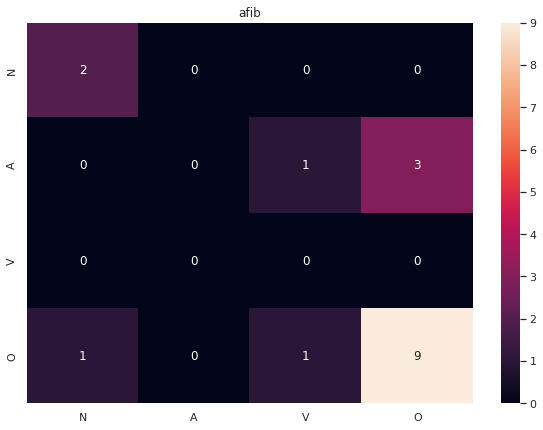

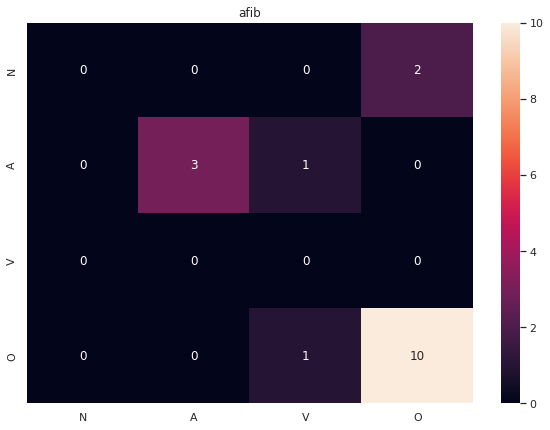

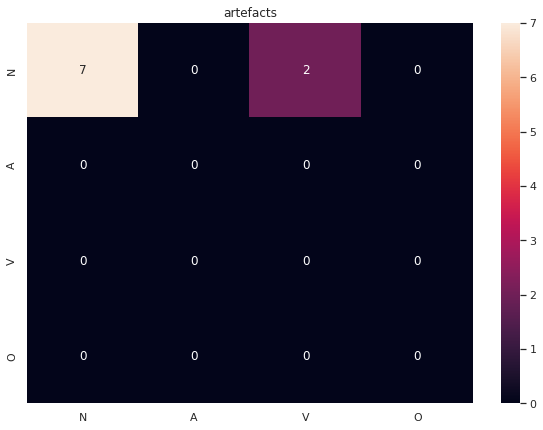

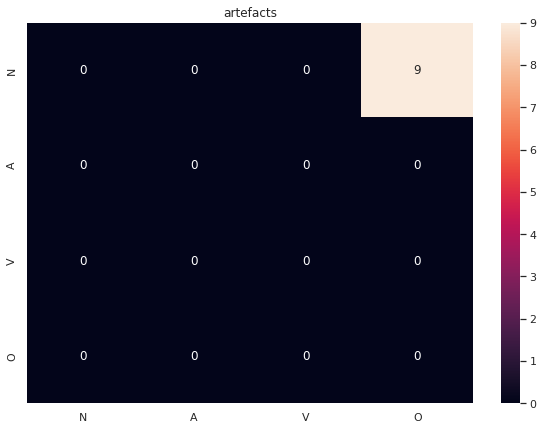

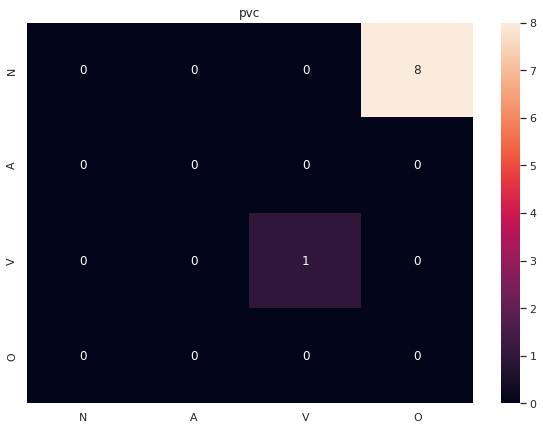

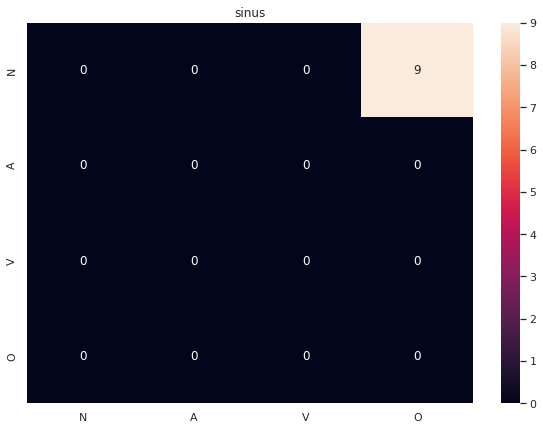

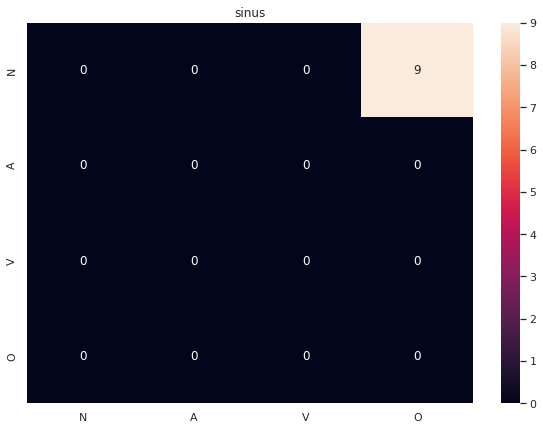

In [0]:
def display_confusion(ecg_id, truth, predictions):
    """Display a confusion matrix for the classification problem"""
    # Inconsistent number of samples: truth.shape vs predictions.shape
    if len(truth) != len(predictions):
        return None
        
    confusion = confusion_matrix(truth[CATEGORY_NAME].values, predictions[CATEGORY_NAME].values, labels=["N", "A", "V", "O"])

    plt.figure(figsize = (10,7))
    plt.title(ecg_id)
    sns.heatmap(pd.DataFrame(confusion, index = [i for i in "NAVO"], columns = [i for i in "NAVO"]), annot=True)


for ecg_id in ["afib", "artefacts", "pvc", "sinus"]:
    ecg, annotations = load(ecg_id)
    truth = extract_waves(annotations['truth'], 'QRS')
    predictions_A = extract_waves(annotations['ann_A'], 'QRS')
    predictions_B = extract_waves(annotations['ann_B'], 'QRS')

    display_confusion(ecg_id, truth, predictions_A)
    display_confusion(ecg_id, truth, predictions_B)

**ANSWER**

Other ideas of improvements:
- Split the long signal into chunks of smaller signals and use [Dask](https://dask.org/) to make the Pandas code scale

- Compute other basic summary statistics (average, mean, stdev, kurtosis, quantiles)
- **Advanced** time series techniques from the [statsmodels](https://www.statsmodels.org) library: [Hodrick-Prescott-Filter](https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_filters.html#Hodrick-Prescott-Filter), [STL Decomposition](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html)
- Representing signals in smaller spaces: Discrete Fourier Transform
- Advanced signal processing NN based representation techniques, [see this talk by Geoffroy Peeters](https://www.college-de-france.fr/site/en-stephane-mallat/seminar-2020-02-12-11h00.htm). Interesting visualizations at:
    - 27:18, classical ML features techniques
    - 36:08, applying image neural nets to 1D signals
    - 1:02:30, multi-label diagram for soundtracks
    - 1:17:00, similarity recommendations between two signals with embeddings

Neural networks are interesting because they provide the idea of **universal embeddings** just by collecting some of their final layers outputs and **interesting analogies** come from the progress in CV and NLP in the last 3 years.